<font size=18>POC Classification d'articles CNN Multichannel</font>

approche de reference:<br>
https://www.kdnuggets.com/2020/06/naive-bayes-algorithm-everything.html<br>
nouvelle approche:<br>
https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/<br>

In [3]:
#pip install shap

In [4]:
#pip install interpret

In [5]:
#pip freeze

In [6]:
!python --version

Python 3.9.18


In [159]:
#builtin
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import datetime
import os, sys, time, random

#data
import pandas as pd
import numpy as np
from numpy import array
import pickle 
from pickle import load, dump

#nlp
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords

# viz
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report, precision_recall_curve

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate

from keras.models import load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D

from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret import show
from interpret.blackbox import ShapKernel

os.environ["OMP_NUM_THREADS"] = '4'

# Préparation

## Download et options

In [10]:
# download
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cedric\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cedric\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cedric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\cedric\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cedric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [11]:
#init sns
sns.set()

## chargement des données

In [13]:
#fichier données 
data = './data/'
os.listdir(data)

['flipkart_com-ecommerce_sample_1050.csv']

In [14]:
#chargement dataframe
fn = data + 'flipkart_com-ecommerce_sample_1050.csv'
df = pd.read_csv(fn)
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [15]:
df.shape

(1050, 15)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [17]:
df.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [18]:
df=df[['description','product_category_tree']].copy()

In [19]:
df

,description,product_category_tree
0,Key Features of Elegance Polyester Multicolor ...,"[""Home Furnishing >> Curtains & Accessories >>..."
1,Specifications of Sathiyas Cotton Bath Towel (...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
2,Key Features of Eurospa Cotton Terry Face Towe...,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T..."
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
4,Key Features of Jaipur Print Cotton Floral Kin...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>..."
...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1046,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1047,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."
1048,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >..."


In [20]:
def extractCateg(chaine):
    chaine=chaine.replace('["', '').split(' >> ')[0]
    return chaine


df['category']=df.product_category_tree.apply(extractCateg)
df['category'].value_counts()

category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

# Nettoyage des textes

## Fonction de nettoyage

In [23]:
def processText(doc,
                  rejoin=False,
                  lemm_or_stemm='stem',
                  list_rare_words=None,
                  min_len_word=3,
                  force_is_alpha=True,
                  eng_words=None,
                  extra_words=None,
                  stop_words=None,
                  test=None) : 
    """
    cf process_text_1 but with list_unique_words, min_len_word, and force_is_alpha

    positional arguments :
    -----------------------------------------------------------
    doc : str : the document to process (text in str format)

    opts args :
    -----------------------------------------------------------
    rejoin : bool : si True retourne une string sinon retourne une liste de tokens
    lemm_or_stemm : str : si lem lemmentize sinon stemmentize
    list_rare_words : list : liste des mots rare a exclure
    min_len_word : int : le minimum des mots a ne pas exclure
    force_is_alpha : int : si 1, exclue tous les tokens avec un caractere numérique
    eng_words : list : liste de mots anglais
    extra_words : list : liste des mots a enlever

    return :
    -----------------------------------------------------------
    une string (si rejoin est True) ou une liste de tokens
    """

    # list_unique_words
    if not list_rare_words :
        list_rare_words = []
    if test:
        print(f'\nTexte original ({len(doc)} caractères): {doc}')

    # lower
    doc = doc.lower().strip()
    if test:
        print(f'\nPassage minuscule ({len(doc)} caractères): {doc}')

    #tokenize
    tokenizer = RegexpTokenizer(r"\w+")
    raw_tokens_list = tokenizer.tokenize(doc)
    if test:
        print(f'\nTokenisation ({len(raw_tokens_list)} mots): {raw_tokens_list}')

    # classics stopwords
    if stop_words:
        cleaned_tokens_list = [ w for w in raw_tokens_list if w not in stop_words]
    else:
        cleaned_tokens_list = raw_tokens_list
    if test:
        print(f'\nSuppression stopwords ({len(cleaned_tokens_list)} mots): {cleaned_tokens_list}')

    ##############################################################################

    #no rare tokens
    non_rare_tokens = [ w for w in cleaned_tokens_list if w not in list_rare_words]
    if test:
        print(f'\nSuppression mots rares ({len(non_rare_tokens)} mots): {non_rare_tokens}')

    # no more len words
    more_than_N = [ w for w in non_rare_tokens if len(w) >= min_len_word]
    if test:
        print(f'\nSuppression mots au dessous de {min_len_word} lettres ({len(more_than_N)} mots): {more_than_N}')

    # only alpha chars
    if force_is_alpha :
        alpha_tokens = [ w for w in more_than_N if w.isalpha()]
    else :
        alpha_tokens = more_than_N
    if test:
        print(f'\nCaractères alpha ({len(alpha_tokens)} mots): {alpha_tokens}')

    ##############################################################################

    # stem or lem
    if lemm_or_stemm == 'lem' :
        trans = WordNetLemmatizer()
        trans_text = [trans.lemmatize(i) for i in alpha_tokens]
    else :
        trans = PorterStemmer()
        trans_text = [trans.stem(i) for i in alpha_tokens]
    if test:
        print(f'\nApplication de {lemm_or_stemm} ({len(trans_text)} mots): {trans_text}')

    ##############################################################################

    # in english
    if eng_words :
        engl_text = [ i for i in trans_text if i in eng_words]
    else :
        engl_text = trans_text
    if test:
        print(f'\nFiltre dictionnaire anglais ({len(engl_text)} mots): {engl_text}')

    ##############################################################################

    # drop extra_words tokens
    if extra_words :
        final = [ w for w in engl_text if w not in extra_words]
    else:
        final = engl_text
    if test:
        print(f'\nSuppression d\'extra-words ({len(final)} mots): {final}')

    ##############################################################################

    # Gestion du retour
    if rejoin :
        return " ".join(final)
    return final

In [24]:
def display_tokens_info(tokens,echantillon=None):
    """affichage infos corpus"""
    retour=f'nb tokens {len(tokens)}, nb tokens uniques {len(set(tokens))}'
    if echantillon != None:
        print(f'\n échantillon :\n{tokens[:30]}')
    return retour

## Stopwords

In [26]:
eng_words = [i.lower() for i in words.words()]
ps = PorterStemmer()
eng_words_stem = [ps.stem(i) for i in eng_words]

stop_words = set(stopwords.words('english'))

# rassemblement du corpus entier
raw_corpus = "".join(df.description.values)
print(f'\néchantillon de tokens du corpus : \n{raw_corpus[:1000]}')

# nombre de valeurs dans le corpus
print(f'\nnombre de tokens dans le corpus : {len(raw_corpus)}')

# traitement du corpus entier et comptage des individus
corpus = processText(raw_corpus)
print(f'\nétat après traitement du corpus : {display_tokens_info(corpus)}')


échantillon de tokens du corpus : 
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly fil

In [27]:
mots_corpus = pd.Series(corpus).value_counts()
mots_rares = mots_corpus[mots_corpus==1]
print(f'\nmots rares : {len(mots_rares)}')
liste_mots_rares = list(mots_rares.index)
mots_rares = pd.DataFrame({'words' : liste_mots_rares})


mots rares : 1166


## Clean Text

In [29]:
def cleanText(doc) :
    """lancement du nettoyage final"""
    new_doc = processText(doc,
                  rejoin=True,
                  lemm_or_stemm='lemm',
                  list_rare_words=liste_mots_rares,
                  eng_words=eng_words_stem,
                  extra_words=None)
    return new_doc

In [30]:
file_path = 'dfCleaned.pkl'
if os.path.exists(file_path):
    df = pd.read_pickle(file_path)
else:
    temps_cleaning_debut = time.time()
    df['clean_description'] = df.description.apply(cleanText)
    temps_cleaning = np.round(time.time() - temps_cleaning_debut,4)
    pd.to_pickle(df, file_path)
    saveResults(['Cleaning Corpus',temps_cleaning,''])

# Prépatation pour comparaison des résultats

In [32]:
resultatsModeles = pd.DataFrame()

def saveResults(toSave):
    global resultatsModeles
    if 'Modèle' in resultatsModeles.columns:
        modeles_existants = dict(resultatsModeles['Modèle'])
        if toSave[0] in modeles_existants.values(): # si enregistrement existe on met a jour
            id = resultatsModeles.loc[resultatsModeles['Modèle']==toSave[0]].index[0]
            print(f'modèle existant on met à jour lindex {id}')
            resultatsModeles.iloc[id,1] = toSave[1]
            resultatsModeles.iloc[id,2] = toSave[2]
            resultatsModeles.iloc[id,3] = toSave[3]
        else:
            print(f'modèle inconnu on ajoute') # si enregistrement n'existe pas on ajoute
            resultatsModeles = resultatsModeles._append({'Modèle': toSave[0], 'Temps': toSave[1], 'F1Score': toSave[2], 'Accuracy': toSave[3]}, ignore_index=True)
    else:
        # premier enregistrement
        resultatsModeles = resultatsModeles._append({'Modèle': toSave[0], 'Temps': toSave[1], 'F1Score': toSave[2], 'Accuracy': toSave[3]}, ignore_index=True)


## Fonctions

In [34]:
# Sauvegarder un Dataset vers un fichier
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)


# load a clean dataset
def load_dataset(filename):
    return load(open(filename, 'rb'))


def confusionMatrix(y_test_values, y_pred_values, liste_categories, ModelName):
    acc_score = accuracy_score(y_test_values, y_pred_values)
    conf_mat = confusion_matrix(
            y_test_values, y_pred_values, labels = liste_categories)    
    print(f"Accuracy Score: {acc_score}\n\n")
    df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_categories],
                  columns = liste_categories)
    fig = plt.figure(figsize=(6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.title(f"Matrice de confusion pour le {ModelName}", pad= 20)
    plt.xlabel("Classes prédites")
    plt.ylabel("Classes réelles")
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    return acc_score

## Visualisation Datas

In [36]:
df = pd.read_pickle('dfCleaned.pkl')
df.sample(10)

,description,product_category_tree,category,clean_description
326,Buy TRENDnet TEW-752DRU only for Rs. 5199 from...,"[""Computers >> Network Components >> Routers >...",Computers,buy tew onli for from onli genuin product day ...
453,Bed & Bath Cotton Floral Double Bedsheet (1 Be...,"[""Home Furnishing >> Bed Linen >> Bedsheets""]",Home Furnishing,bed bath cotton floral doubl pillow cover purp...
991,Seven Seas Stainless Steel Twisting Pull Corks...,"[""Kitchen & Dining >> Bar & Glassware >> Bar A...",Kitchen & Dining,seven sea stainless steel twist pull corkscrew...
838,Techone+ Flexible SE122103-GREEN USB Led Light...,"[""Computers >> Laptop Accessories >> USB Gadge...",Computers,flexibl green led light green price usabl with...
384,Flipkart.com: Buy Denver Rage Hamilton Honour ...,"[""Beauty and Personal Care >> Fragrances >> De...",Beauty and Personal Care,buy hamilton set onli for from onli genuin pro...
5,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",Watches,time analog watch for boy buy time analog watc...
524,"Noise NOSWW001 Analog Watch - For Men, Women ...","[""Watches >> Wrist Watches >> Noise Wrist Watc...",Watches,nois analog watch for men buy nois analog watc...
386,Flipkart.com: Buy French Factor Man of the Yea...,"[""Beauty and Personal Care >> Fragrances >> De...",Beauty and Personal Care,buy french man the year deodor gift set set on...
59,Specifications of Brillare Science Dandruff Co...,"[""Beauty and Personal Care >> Combos and Kits ...",Beauty and Personal Care,specif scienc dandruff control shampoo set set...
978,Specifications of Deep kitchen press Steel Gra...,"[""Kitchen & Dining >> Kitchen Tools >> Chopper...",Kitchen & Dining,specif deep kitchen press steel grater and sli...


## Préparation des données

In [38]:
transformerBase = ColumnTransformer(transformers=[('category', OneHotEncoder(), ['category'])],
                                verbose_feature_names_out=False)
transformerBase.fit(df[['category']])
liste_categories = transformerBase.get_feature_names_out()
y = transformerBase.transform(df[['category']]).toarray()

new_liste = []
for categorie in liste_categories:
    new_liste.append(categorie.replace('category_',''))
liste_categories = np.array(new_liste)
print(f"Liste des catégories: {liste_categories}\n")

X = df['clean_description']
print(f"Taille des données en entrée {X.shape}\n")
print(f"Taille des labels de sortie {y.shape}\n")

Liste des catégories: ['Baby Care' 'Beauty and Personal Care' 'Computers'
 'Home Decor & Festive Needs' 'Home Furnishing' 'Kitchen & Dining'
 'Watches']

Taille des données en entrée (1050,)

Taille des labels de sortie (1050, 7)



## Séparation et stockage des données

> Nous gardons 10% des données pour effectuer le test

In [41]:
X_train, X_test, y_train, y_test, y_trainBayes, y_testBayes = train_test_split(X, y, df['category'], test_size=0.10, stratify=y, random_state=42)
save_dataset([X_train,y_train], 'train.pkl')
save_dataset([X_test,y_test], 'test.pkl')
save_dataset([X,y], 'allData.pkl')

Saved: train.pkl
Saved: test.pkl
Saved: allData.pkl


# Approche Classique - Naive Bayes Classifier for Multinomial Models

In [43]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
temps_Bayes_debut = time.time()
nb.fit(X_train, y_trainBayes)
temps_Bayes = np.round(time.time() - temps_Bayes_debut,4)

print(f"Train: {X_train.shape}, Test: {y_trainBayes.shape}")

Train: (945,), Test: (945,)


## Résultats



Rapport de classification pour le modèle Naive Bayes Classifier

                            precision    recall  f1-score   support

                 Baby Care       0.81      0.87      0.84        15
  Beauty and Personal Care       0.93      0.93      0.93        15
                 Computers       1.00      0.93      0.97        15
Home Decor & Festive Needs       0.87      0.87      0.87        15
           Home Furnishing       1.00      0.93      0.97        15
          Kitchen & Dining       0.88      1.00      0.94        15
                   Watches       1.00      0.93      0.97        15

                  accuracy                           0.92       105
                 macro avg       0.93      0.92      0.92       105
              weighted avg       0.93      0.92      0.92       105

Accuracy Score: 0.9238095238095239


CPU times: total: 93.8 ms
Wall time: 171 ms


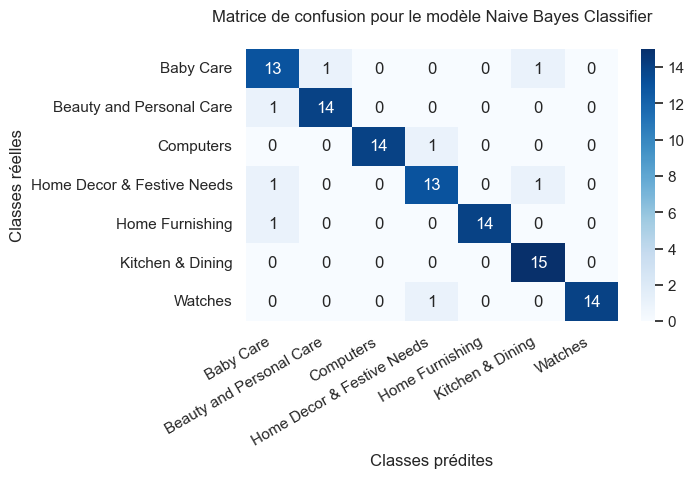

In [45]:
%%time
ModelName = "modèle Naive Bayes Classifier"
from sklearn.metrics import classification_report
y_predBayes = nb.predict(X_test)
print(f"\n\nRapport de classification pour le {ModelName}\n")
print(classification_report(y_testBayes, y_predBayes, target_names=liste_categories))
f1Bayes = f1_score(y_testBayes, y_predBayes, average='micro')
AccBayes = confusionMatrix(y_testBayes, y_predBayes, liste_categories, ModelName)
saveResults([ModelName, temps_Bayes, f1Bayes, AccBayes])

# Nouvelle Approche - Modèle Multichannel CNN

## Définition du modèle

In [48]:
# define the model
def define_model(length, vocab_size):
    inputs = Input(shape=(length,))
    # channel 1
    embedding1 = Embedding(vocab_size, 100)(inputs)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    embedding2 = Embedding(vocab_size, 100)(inputs)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    embedding3 = Embedding(vocab_size, 100)(inputs)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # channel 4
    embedding4 = Embedding(vocab_size, 100)(inputs)
    conv4 = Conv1D(filters=32, kernel_size=10, activation='relu')(embedding4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)
    flat4 = Flatten()(pool4)
    # channel 5
    embedding5 = Embedding(vocab_size, 100)(inputs)
    conv5 = Conv1D(filters=32, kernel_size=12, activation='relu')(embedding5)
    drop5 = Dropout(0.5)(conv5)
    pool5 = MaxPooling1D(pool_size=2)(drop5)
    flat5 = Flatten()(pool5)
    # merge
    merged = concatenate([flat1, flat2, flat3, flat4, flat5])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(7, activation='softmax')(dense1)
    model = Model(inputs=[inputs], outputs=outputs)
    # compile
    model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model


In [49]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [50]:
# load training dataset
trainLines, trainLabels = load_dataset('train.pkl')
# create tokenizer
temps_poc_debut = time.time()
tokenizer = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
print(trainX.shape)
# define model
modelPoc = define_model(length, vocab_size)
# fit model
historyPoc = modelPoc.fit([trainX], array(trainLabels), epochs=10, batch_size=16)
temps_poc = round(time.time() - temps_poc_debut, 4)
# save the model
modelPoc.save('modelPoc.h5')

Max document length: 446
Vocabulary size: 2561
(945, 446)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 446)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 446, 100)     256100      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 446, 100)     256100      ['input_1[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 446, 100)     256100      ['input_1[0][0]']                
                                    

## Résultats

In [52]:
# load datasets
trainLines, trainLabels = load_dataset('train.pkl')
testLines, testLabels = load_dataset('test.pkl')
allLines, allLabels = load_dataset('allData.pkl')

# create tokenizer
tokenizerPoc = create_tokenizer(trainLines)
# calculate max document length
length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizerPoc.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizerPoc, trainLines, length)
testX = encode_text(tokenizerPoc, testLines, length)
allX = encode_text(tokenizerPoc, allLines, length)
print(f"Train: {trainX.shape}, Test: {testX.shape}")

# load the model
modelPoc = load_model('modelPoc.h5')

# evaluate model on training dataset
loss, acc = modelPoc.evaluate([trainX], array(trainLabels), verbose=0)
print('Train Accuracy: %f' % (acc*100))

# evaluate model on test dataset dataset
loss, acc = modelPoc.evaluate([testX],array(testLabels), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Max document length: 446
Vocabulary size: 2561
Train: (945, 446), Test: (105, 446)
Train Accuracy: 99.682540
Test Accuracy: 93.333334


In [54]:
#trainLabels[0]



Rapport de classification pour le modèle Multichannel CNN

                            precision    recall  f1-score   support

                 Baby Care       0.87      0.87      0.87        15
  Beauty and Personal Care       0.93      0.93      0.93        15
                 Computers       1.00      0.93      0.97        15
Home Decor & Festive Needs       0.88      0.93      0.90        15
           Home Furnishing       0.93      0.93      0.93        15
          Kitchen & Dining       0.94      1.00      0.97        15
                   Watches       1.00      0.93      0.97        15

                  accuracy                           0.93       105
                 macro avg       0.94      0.93      0.93       105
              weighted avg       0.94      0.93      0.93       105

Accuracy Score: 0.9333333333333333


modèle inconnu on ajoute
CPU times: total: 3.66 s
Wall time: 396 ms


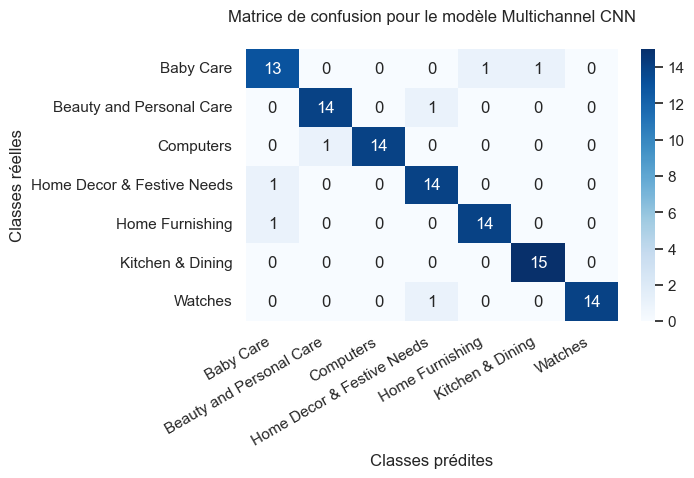

In [55]:
%%time
ModelName = "modèle Multichannel CNN"
from sklearn.metrics import classification_report
y_predPocTemp = modelPoc.predict([testX], verbose=0)
y_predPoc = liste_categories[np.argmax(y_predPocTemp, axis = 1)]
y_testPoc = liste_categories[np.argmax(y_test, axis = 1)]
print(f"\n\nRapport de classification pour le {ModelName}\n")
print(classification_report(y_testPoc, y_predPoc, target_names=liste_categories))
f1Poc = f1_score(y_testPoc, y_predPoc, average='micro')
accPoc = confusionMatrix(y_testPoc, y_predPoc, liste_categories, ModelName)
saveResults([ModelName, temps_poc, f1Poc, accPoc])

## Courbes Loss & Accuracy

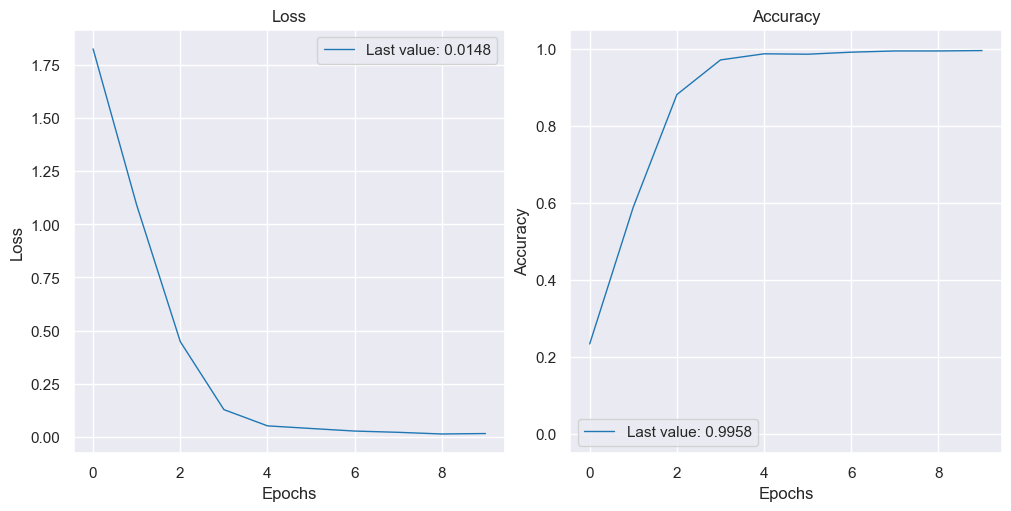

In [57]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(historyPoc)
plot_history(historyPoc, path="multichannel-convolutional-neural-network.png")
plt.close()

# Résultats et Comparaisons

In [59]:
resultatsModeles

,Modèle,Temps,F1Score,Accuracy
0,modèle Naive Bayes Classifier,0.0691,0.923810,0.923810
1,modèle Multichannel CNN,19.9751,0.933333,0.933333


## Exemple de Prédictions

In [61]:
VisuResult = pd.DataFrame()
y_predAllBayes = nb.predict(X)
y_predAllPoc = modelPoc.predict([allX], verbose=0)
VisuResult['CleanDescription'] = X
VisuResult['ClassifBayes'] = y_predAllBayes
VisuResult['ClassifPoc'] = liste_categories[np.argmax(y_predAllPoc, axis = 1)]
VisuResult['TrueLabels'] = liste_categories[np.argmax(y, axis = 1)]
VisuResult['SatusBayes'] = np.where(VisuResult['ClassifBayes'] == VisuResult['TrueLabels'], '', 'Failed')
VisuResult['SatusPoc'] = np.where(VisuResult['ClassifPoc'] == VisuResult['TrueLabels'], '', 'Failed')
VisuResult.sample(20)

,CleanDescription,ClassifBayes,ClassifPoc,TrueLabels,SatusBayes,SatusPoc
107,artisan creation checker singl quilt comfort b...,Home Furnishing,Home Furnishing,Home Furnishing,,
263,buy handicraft showpiec for handicraft showpie...,Home Decor & Festive Needs,Home Decor & Festive Needs,Home Decor & Festive Needs,,
223,roll pizza cutter stainless steel pack price p...,Kitchen & Dining,Kitchen & Dining,Kitchen & Dining,,
635,key featur wow babi girl gather red dress summ...,Baby Care,Baby Care,Baby Care,,
185,ceram mug price coffe mug ador and fantast cof...,Kitchen & Dining,Kitchen & Dining,Kitchen & Dining,,
177,ceram mug price coffe mug ador and fantast cof...,Kitchen & Dining,Kitchen & Dining,Kitchen & Dining,,
924,buy brillianc lip color for from price onli ge...,Beauty and Personal Care,Beauty and Personal Care,Beauty and Personal Care,,
624,specif solid singl breast casual blazer gener ...,Baby Care,Baby Care,Baby Care,,
1045,empow extra larg self adhes sticker pack price...,Home Decor & Festive Needs,Baby Care,Baby Care,Failed,
586,sonata dean analog watch for men buy sonata de...,Watches,Watches,Watches,,


## Feature importance

In [454]:
words2Index = tokenizerPoc.word_index
index2Words = dict(zip(words2Index.values(), words2Index.keys()))

In [338]:
categoriesjson = pd.Series(liste_categories).to_json(orient='values')

In [169]:
explainer1 = shap.KernelExplainer(modelPoc.predict,shap.kmeans(trainX, 100))

4/4 [==============================] - 0s 8ms/step


In [187]:
shap_values = explainer1.shap_values(testX[:15])

  0%|          | 0/15 [00:00<?, ?it/s]

9188/9188 [==============================] - 100s 11ms/step


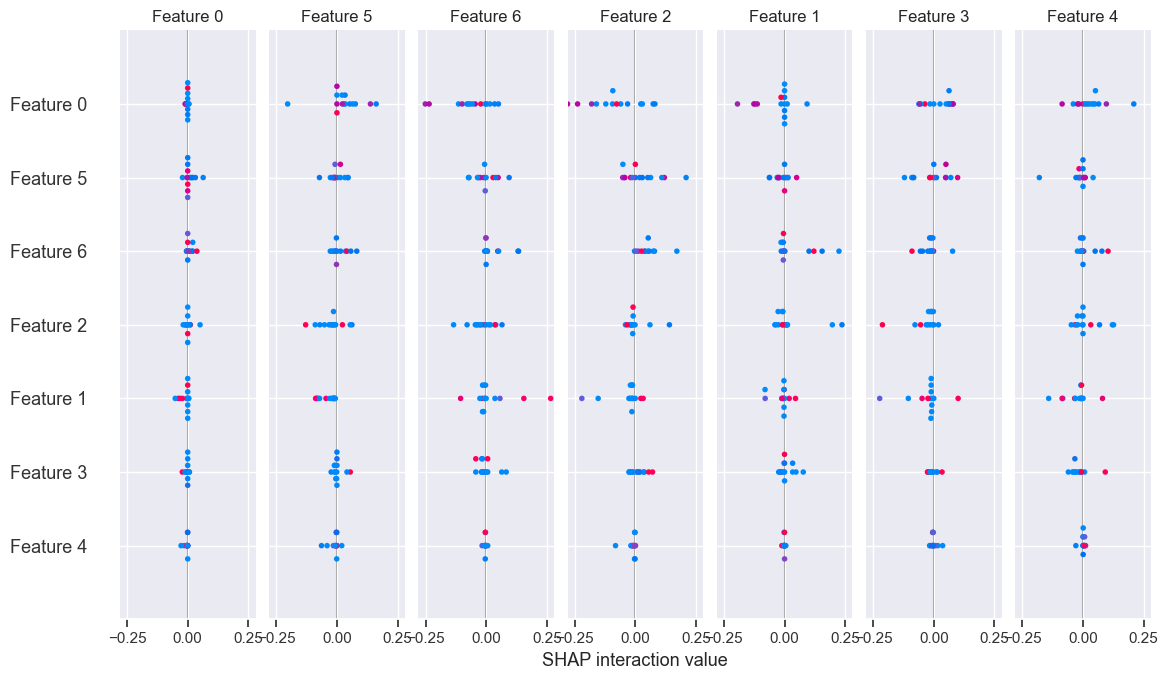

In [244]:
shap.summary_plot(shap_values,testX[:15])

In [195]:
shap_values.shape

(15, 446, 7)

In [328]:
len(list(index2Words.values()))

2560

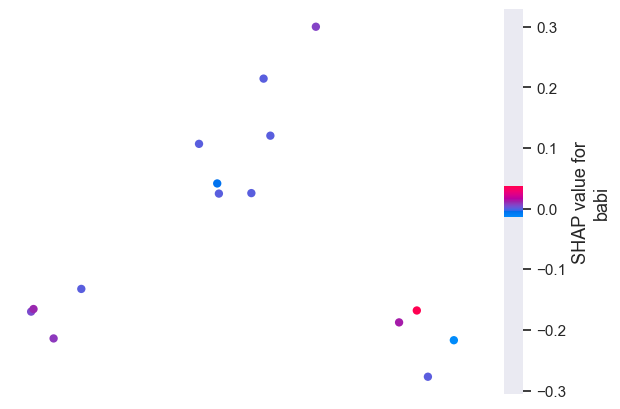

In [473]:
#Visualisation de l'importance du mot babi dans la classe Baby care
shap.plots.embedding(words2Index['babi'], shap_values[:,:,0], feature_names=index2Words, show=True)

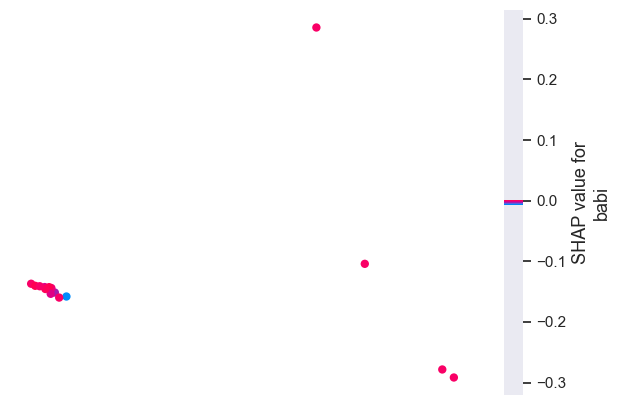

In [500]:
#Visualisation de l'importance du mot babi dans la classe Watches
shap.plots.embedding(words2Index['babi'], shap_values[:,:,6], feature_names=index2Words, show=True)

In [441]:
shap.plots.force(explainer1.expected_value[0], shap_values[:,:,0], out_names=categoriesjson)

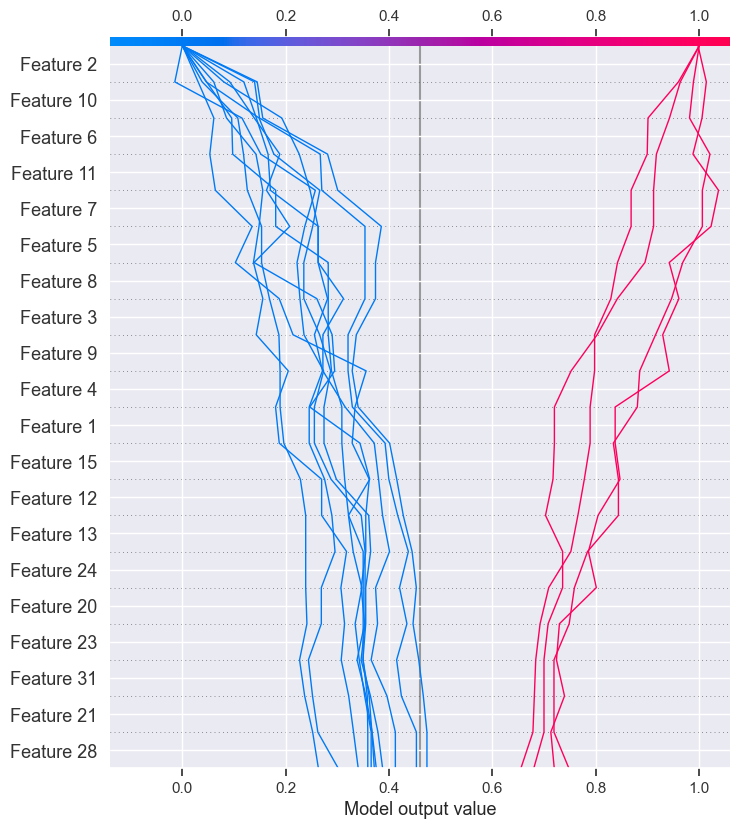

In [477]:
#Visualisation de l'importance des features des 15 premiers items dans la classe Baby care
shap.plots.decision(explainer1.expected_value[0], shap_values[:,:,0])